In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dipy.reconst.dki as dki
import dipy.reconst.dti as dti
from dipy.core.gradients import gradient_table
from dipy.data import get_fnames
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti
from dipy.segment.mask import median_otsu
from scipy.ndimage import gaussian_filter

In [2]:
# Setting the path of data
from os.path import  join
fdwi = join('DICOM_T1_DTI_dtionly/NII/ep2d_diff_iso2_mddw_30_p3.nii.gz')
print(fdwi)

fbval = join('DICOM_T1_DTI_dtionly/NII/ep2d_diff_iso2_mddw_30_p3.bval')
print(fbval)

fbvec = join('DICOM_T1_DTI_dtionly/NII/ep2d_diff_iso2_mddw_30_p3.bvec')
print(fbvec)

DICOM_T1_DTI_dtionly/NII/ep2d_diff_iso2_mddw_30_p3.nii.gz
DICOM_T1_DTI_dtionly/NII/ep2d_diff_iso2_mddw_30_p3.bval
DICOM_T1_DTI_dtionly/NII/ep2d_diff_iso2_mddw_30_p3.bvec


In [3]:
# load the DIT data(*.nii.gz, *.bval and *.bvec)
data, affine, img = load_nifti(fdwi, return_img=True)
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
gtab = gradient_table(bvals, bvecs)

print('data.shape (%d, %d, %d, %d)' % data.shape)

data.shape (128, 128, 61, 136)


In [4]:
# Mask and crop the data
from dipy.segment.mask import median_otsu

maskdata, mask = median_otsu(data, vol_idx=[0, 1], median_radius=4, numpass=4,
                             autocrop=True, dilate=2)

print('maskdata.shape (%d, %d, %d, %d)' % maskdata.shape)

maskdata.shape (77, 87, 61, 136)


In [5]:
# Denoice with Gaussian filter
fwhm = 1.25
gauss_std = fwhm / np.sqrt(8 * np.log(2))  # converting fwhm to Gaussian std
data_smooth = np.zeros(maskdata.shape)
for v in range(maskdata.shape[-1]):
    data_smooth[..., v] = gaussian_filter(maskdata[..., v], sigma=gauss_std)

In [6]:
# TensorModel
tenmodel = dti.TensorModel(gtab)
tenfit = tenmodel.fit(data_smooth)

In [7]:
# Calculate FA, MD, AD and RD
dti_FA = tenfit.fa
dti_MD = tenfit.md
dti_AD = tenfit.ad
dti_RD = tenfit.rd


In [8]:
# FA to RGB
from dipy.io.image import save_nifti
from dipy.reconst.dti import color_fa

FA = np.clip(dti_FA, 0, 1)
RGB = color_fa(FA, tenfit.evecs)

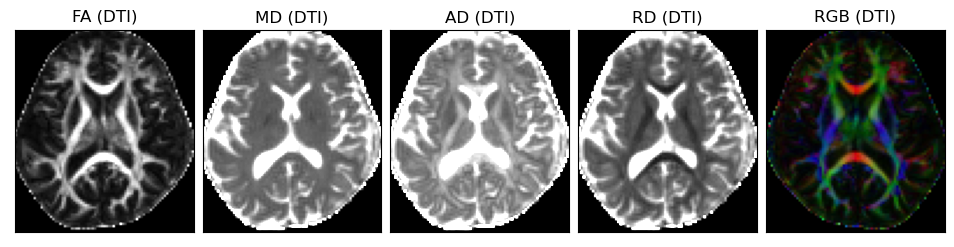

In [9]:
# Plot result of tensor
axial_middle = data.shape[2] // 2

fig1, ax = plt.subplots(1, 5, figsize=(12, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

fig1.subplots_adjust(hspace=0.3, wspace=0.05)

ax.flat[0].imshow(dti_FA[:, :, axial_middle].T, cmap='gray',
                  vmin=0, vmax=0.7, origin='lower')
ax.flat[0].set_title('FA (DTI)')
ax.flat[1].imshow(dti_MD[:, :, axial_middle].T, cmap='gray',
                  vmin=0, vmax=2.0e-3, origin='lower')
ax.flat[1].set_title('MD (DTI)')
ax.flat[2].imshow(dti_AD[:, :, axial_middle].T, cmap='gray',
                  vmin=0, vmax=2.0e-3, origin='lower')
ax.flat[2].set_title('AD (DTI)')
ax.flat[3].imshow(dti_RD[:, :, axial_middle].T, cmap='gray',
                  vmin=0, vmax=2.0e-3, origin='lower')
ax.flat[3].set_title('RD (DTI)')
ax.flat[4].imshow(np.rot90(RGB[:, :, axial_middle,:],3),
                  origin='lower')
ax.flat[4].set_title('RGB (DTI)')


plt.show()
fig1.savefig('images/Diffusion_tensor_measures_from_DTI_of_HW4.png')

In [10]:
# Save result

save_nifti('Dicom_T1_DTI_dtionly/NII/tensors_fa.nii.gz', dti_FA.astype(np.float32), affine)
save_nifti('Dicom_T1_DTI_dtionly/NII/tensors_md.nii.gz', dti_MD.astype(np.float32), affine)
save_nifti('Dicom_T1_DTI_dtionly/NII/tensors_ad.nii.gz', dti_FA.astype(np.float32), affine)
save_nifti('Dicom_T1_DTI_dtionly/NII/tensors_rd.nii.gz', dti_FA.astype(np.float32), affine)
save_nifti('Dicom_T1_DTI_dtionly/NII/tensors_rgb.nii.gz', np.array(255 * RGB, 'uint8'), affine)